In [1]:
from scipy.stats import nbinom, binom, poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from scipy.stats import kendalltau
from scipy.stats import spearmanr
import os
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint
import inspect

In [2]:
path = r'C:/Users/felix.oechslein/Desktop/Analysen Thalia, Mai/verarbeitete_daten'
filename = 'Pivot_Trans_Privat_ohneApple_Langzeitkunde.csv'

df_trans_werte = pd.read_csv(os.path.join(path, filename))

In [3]:
path = r'C:/Users/felix.oechslein/Desktop/Analysen Thalia, Mai/verarbeitete_daten'
filename = 'Pivot_LY_Privat_ohneApple_Langzeitkunde.csv'

df_LY = pd.read_csv(os.path.join(path, filename))

In [4]:
path = r'C:/Users/felix.oechslein/Desktop/Analysen Thalia, Mai/verarbeitete_daten'
filename = 'Pivot_HY_Privat_ohneApple_Langzeitkunde.csv'

df_HY = pd.read_csv(os.path.join(path, filename))

In [5]:
path = r'C:/Users/felix.oechslein/Desktop/Analysen Thalia, Mai/verarbeitete_daten'
filename = 'Pivot_NO_Privat_ohneApple_Langzeitkunde.csv'

df_NO_werte = pd.read_csv(os.path.join(path, filename))

In [6]:
path = r'C:/Users/felix.oechslein/Desktop/Analysen Thalia, Mai/verarbeitete_daten'
filename = 'Pivot_LO_Privat_ohneApple_Langzeitkunde.csv'

df_LO = pd.read_csv(os.path.join(path, filename))

In [7]:
## Alle DataFrame Werte von Float zu int
df_trans_werte = df_trans_werte.astype(int)
df_LY = df_LY.astype(int)
df_HY = df_HY.astype(int)
df_NO_werte = df_NO_werte.astype(int)
df_LO = df_LO.astype(int)

# Transwerte-1 definiert für spätere Berecnungen in der Copula
#df_trans_werte_minusEins = df_trans_werte.loc[:, df_NO_werte.columns != 'iid'] -1
#df_trans_werte_minusEins = df_trans_werte_minusEins.astype(int)

In [8]:
# Entfernen der Zeilen aus df_HY, die nicht in df_trans_werte und df_LO enthalten sind
df_HY = df_HY[df_HY['iid'].isin(df_trans_werte['iid'])]
df_HY = df_HY[df_HY['iid'].isin(df_LO['iid'])]

# Entfernen der Zeilen aus df_trans_werte, die nicht in df_HY, df_NO_werte und df_LY enthalten sind
df_trans_werte = df_trans_werte[df_trans_werte['iid'].isin(df_HY['iid'])]
df_trans_werte = df_trans_werte[df_trans_werte['iid'].isin(df_NO_werte['iid'])]
df_trans_werte = df_trans_werte[df_trans_werte['iid'].isin(df_LY['iid'])]

# Entfernen der Zeilen aus df_LO, die nicht in df_HY enthalten sind
df_LO = df_LO[df_LO['iid'].isin(df_HY['iid'])]

# Entfernen der Zeilen aus df_NO_werte, die nicht in df_trans_werte enthalten sind
df_NO_werte = df_NO_werte[df_NO_werte['iid'].isin(df_trans_werte['iid'])]

# Entfernen der Zeilen aus df_LY, die nicht in df_trans_werte enthalten sind
df_LY = df_LY[df_LY['iid'].isin(df_trans_werte['iid'])]

### Alle DataFrames Indizes resetten, damit man sie gemeinsam identifiziere kann
df_HY = df_HY.reset_index(drop=True)
df_trans_werte = df_trans_werte.reset_index(drop=True)
df_LO = df_LO.reset_index(drop=True)
df_NO_werte = df_NO_werte.reset_index(drop=True)
df_LY = df_LY.reset_index(drop=True)

# NO-1 definiert für spätere Berechnung inder Copula
df_NO_minusEins = df_NO_werte.copy()
df_NO_minusEins.loc[:, df_NO_minusEins.columns != 'iid'] = df_NO_minusEins.loc[:, df_NO_minusEins.columns != 'iid'] -1
df_NO_minusEins = df_NO_minusEins.astype(int)
# transwerte -1 definiert für spätere Berechnung inder Copula
df_trans_werte_minusEins = df_trans_werte.copy()
df_trans_werte_minusEins.loc[:, df_trans_werte_minusEins.columns != 'iid'] = df_trans_werte_minusEins.loc[:, df_trans_werte_minusEins.columns != 'iid'] -1
df_trans_werte_minusEins = df_trans_werte_minusEins.astype(int)

In [9]:
# Siherstellen dass alle dataframes die Kunden in derselben Reihenfolge auflisten
df_NO_minusEins = df_NO_minusEins.sort_values('iid')
df_HY = df_HY.sort_values('iid')
df_trans_werte = df_trans_werte.sort_values('iid')
df_LO = df_LO.sort_values('iid')
df_NO_werte = df_NO_werte.sort_values('iid')
df_LY = df_LY.sort_values('iid')
df_trans_werte_minusEins = df_trans_werte_minusEins.sort_values('iid')

In [10]:
# Ausreißer
arr = np.sum(df_trans_werte[df_trans_werte.columns[df_trans_werte.columns != 'iid']], axis=1)
indices_ausreisser_käufe = np.argsort(arr)[-10:]
indices_ausreisser_käufe_2 = [251, 220]
indices_ausreisser_käufe = np.concatenate([indices_ausreisser_käufe, indices_ausreisser_käufe_2])
indices_ausreisser_öffnungen = [443, 387, 408]
ausreisser_pos = np.concatenate([indices_ausreisser_öffnungen, indices_ausreisser_käufe])

In [11]:
# Zeilen löschen
df_NO_minusEins = df_NO_minusEins.drop(ausreisser_pos).reset_index(drop = True)
df_HY = df_HY.drop(ausreisser_pos).reset_index(drop = True)
df_trans_werte = df_trans_werte.drop(ausreisser_pos).reset_index(drop = True)
df_LO = df_LO.drop(ausreisser_pos).reset_index(drop = True)
df_NO_werte = df_NO_werte.drop(ausreisser_pos).reset_index(drop = True)
df_LY = df_LY.drop(ausreisser_pos).reset_index(drop = True)
df_trans_werte_minusEins = df_trans_werte_minusEins.drop(ausreisser_pos).reset_index(drop = True)

In [31]:
anzahl_kunden = len(df_trans_werte["iid"])
anzahl_kunden

633

In [32]:
anzahl_monate = len(df_trans_werte.columns[df_trans_werte.columns != 'iid'])
anzahl_monate

15

In [33]:
anzahl_states = 2

In [51]:
estimated_params = [ 0.        , -1.84134701,  0.        ,  0.98963076,  0.        ,
        2.68214831,  0.        ,  2.80627766,  0.        , -1.2810976 ,
        0.        ,  0.69838679,  0.        ,  1.45855322,  0.        ,
       -2.13009073,  0.        , -0.04889301,  0.        ,  0.62177964,
        0.33148307,  1.39588074, -1.12147141,  7.70110619,  8.        ,
       -1.20879416,  1.99467476, -1.11065899, -1.89390642,  0.01515651,
        0.17867123, -0.03878318, -0.03539839,  1.03831034]

In [52]:
alpha_size = anzahl_states**2
gamma_size = anzahl_states**2 * 4

alpha = estimated_params[:alpha_size]
gamma = estimated_params[alpha_size:alpha_size+gamma_size]
alpha_o = estimated_params[alpha_size+gamma_size:alpha_size+gamma_size+anzahl_states]
beta_o = estimated_params[alpha_size+gamma_size+anzahl_states:alpha_size+gamma_size+anzahl_states+1]
delta_0 = estimated_params[alpha_size+gamma_size+anzahl_states+1:alpha_size+gamma_size+anzahl_states*2+1]
delta_1 = estimated_params[alpha_size+gamma_size+anzahl_states*2+1:alpha_size+gamma_size+anzahl_states*3+1]
alpha_p = estimated_params[alpha_size+gamma_size+anzahl_states*3+1:alpha_size+gamma_size+anzahl_states*4+1]
beta_p_1 = estimated_params[alpha_size+gamma_size+anzahl_states*4+1:alpha_size+gamma_size+anzahl_states*5+1]
beta_p_2 = estimated_params[alpha_size+gamma_size+anzahl_states*5+1:alpha_size+gamma_size+anzahl_states*6+1]
theta = estimated_params[alpha_size+gamma_size+anzahl_states*6+1:]

In [53]:
delta_0

[7.70110619, 8.0]

In [54]:
delta_1

[-1.20879416, 1.99467476]

In [55]:
alpha_p

[-1.11065899, -1.89390642]

In [56]:
beta_p_1

[0.01515651, 0.17867123]

In [57]:
beta_p_2

[-0.03878318, -0.03539839]

# Tests

#### Maximum LY

In [21]:
df_LY[df_LY.columns[df_LY.columns !="iid"]].min()

1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
dtype: int32

In [22]:
1/(1+np.exp(13.717 - 1.728 * np.log(1)))

1.1035248375531423e-06

In [34]:
df_HY[df_HY.columns[df_HY.columns !="iid"]].values.sum() / (anzahl_kunden * anzahl_monate)

1.5353343865192206

In [64]:
for state in range(2):
    print(np.exp(alpha_p[state] + beta_p_1[state] * 2 + beta_p_2[state] * np.square(2)))

0.2906955759916748
0.18671768290206045


In [47]:
np.exp(-1.852 + 0.135 * 3 - 0.018 * np.square(3))

0.20008760166634962

In [39]:
df_HY[df_HY.columns[df_HY.columns !="iid"]].values.max()

3

In [67]:
np.exp(-1.121) 

0.32595367791394736

# Lambda Interpretation

In [23]:
r = [1.29]

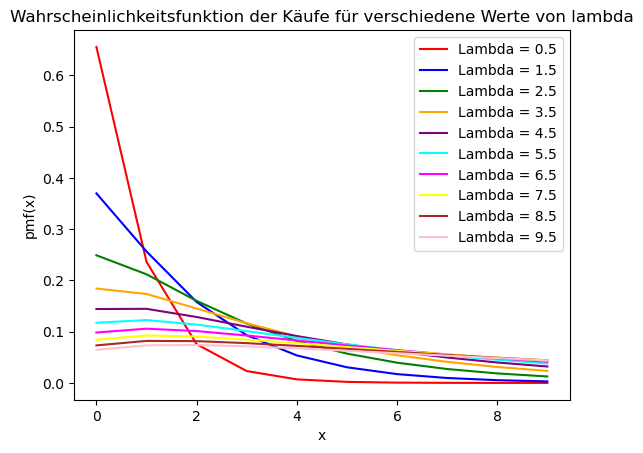

In [114]:
histogram_data = np.zeros((10, 10))

r = [1.29]  # Beispielwert für r
phi = [0]  # Beispielwert für phi

for lambdaY in np.linspace(0.5, 9.5, num=10):
    for value in range(10):
        numerator = math.gamma(value + r[0])
        denominator = math.factorial(value) * math.gamma(r[0])
        gamma_term = numerator / denominator
        pmf = (1 - phi[0]) * gamma_term * (1 + lambdaY / r[0])**(-r[0]) * (1 + r[0] / lambdaY)**(-(value))
        histogram_data[lambdaY.astype(int), value] = pmf

#plt.plot(value_values, histogram_data)

# Farben für die Linien
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'pink']

# Linien mit verschiedenen Farben plotten
for i in range(histogram_data.shape[0]):
    plt.plot(range(10), histogram_data[i], color=colors[i], label=f'Lambda = {i+0.5}')

plt.xlabel('x')
plt.ylabel('pmf(x)')
plt.title('Wahrscheinlichkeitsfunktion der Käufe für verschiedene Werte von lambda')
# Legende anzeigen
plt.legend()

plt.savefig("C:/Users/felix.oechslein/Desktop/Analysen Thalia, Mai/Grafiken/" +
            'Lambda_Veranschaulichung.png', dpi=300)
plt.show()

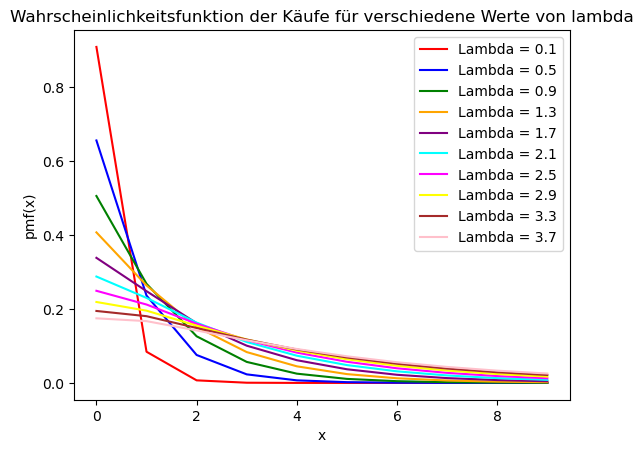

In [26]:
histogram_data = np.zeros((10, 10))

r = [1.29]  # Beispielwert für r
phi = [0]  # Beispielwert für phi

zaehler=0
for lambdaY in np.linspace(0.1, 3.7, num=10):
    for value in range(10):
        numerator = math.gamma(value + r[0])
        denominator = math.factorial(value) * math.gamma(r[0])
        gamma_term = numerator / denominator
        pmf = (1 - phi[0]) * gamma_term * (1 + lambdaY / r[0])**(-r[0]) * (1 + r[0] / lambdaY)**(-(value))
        histogram_data[zaehler, value] = pmf
    zaehler +=1

#plt.plot(value_values, histogram_data)

# Farben für die Linien
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'pink']

# Linien mit verschiedenen Farben plotten
for i in range(histogram_data.shape[0]):
    plt.plot(range(10), histogram_data[i], color=colors[i], label=f'Lambda = {round(i*0.4 + 0.1, 1)}')

plt.xlabel('x')
plt.ylabel('pmf(x)')
plt.title('Wahrscheinlichkeitsfunktion der Käufe für verschiedene Werte von lambda')
# Legende anzeigen
plt.legend()

plt.savefig("C:/Users/felix.oechslein/Desktop/Analysen Thalia, Mai/Grafiken/" +
            'Lambda_Veranschaulichung.png', dpi=300)
plt.show()

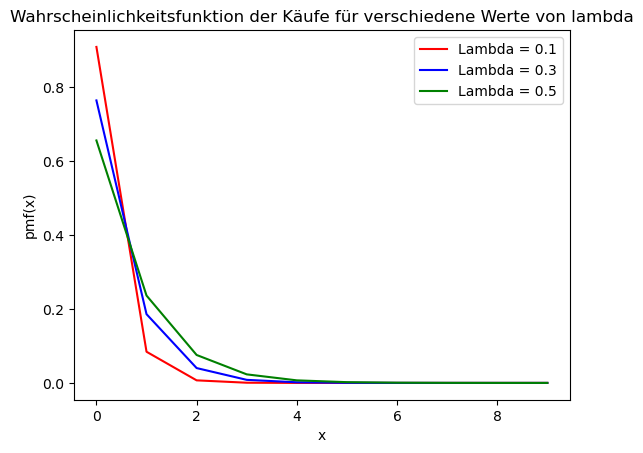

In [49]:
histogram_data = np.zeros((3, 10))

r = [1.29]  # Beispielwert für r
phi = [0]  # Beispielwert für phi

zaehler=0
for lambdaY in np.linspace(0.1, 0.5, num=3):
    for value in range(10):
        numerator = math.gamma(value + r[0])
        denominator = math.factorial(value) * math.gamma(r[0])
        gamma_term = numerator / denominator
        pmf = (1 - phi[0]) * gamma_term * (1 + lambdaY / r[0])**(-r[0]) * (1 + r[0] / lambdaY)**(-(value))
        histogram_data[zaehler, value] = pmf
    zaehler +=1

#plt.plot(value_values, histogram_data)

# Farben für die Linien
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'pink']

# Linien mit verschiedenen Farben plotten
for i in range(histogram_data.shape[0]):
    plt.plot(range(10), histogram_data[i], color=colors[i], label=f'Lambda = {round(i*0.2 + 0.1, 1)}')

plt.xlabel('x')
plt.ylabel('pmf(x)')
plt.title('Wahrscheinlichkeitsfunktion der Käufe für verschiedene Werte von lambda')
# Legende anzeigen
plt.legend()

plt.savefig("C:/Users/felix.oechslein/Desktop/Analysen Thalia, Mai/Grafiken/" +
            'Lambda_Veranschaulichung.png', dpi=300)